## Introduction

In this notebook, we define a problem and prepare the data for creating the model. By looking at column tip_amount we understand that it stores information about the amount of the tip given for each ride. We are interested in to find out what factors have most influence the amount of the tip. We want to build a classifier that uses all information to predict whether a passenger give tip to driver. This is a binary classifier. With such a classifier we want to provide an alert for driver to predict no-tip rides.

In part 2 we predict the tip amount using regression models.


### Import necessary libraries


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from datetime import datetime


load the data from notebook 'Part 1-EDA'

In [2]:
df = pd.read_csv('data.csv', index_col='Unnamed: 0')

C:\Users\Nastaran\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,...,tip_amount,tolls_amount,duration,pickup_hour,pickup_day,dropoff_hour,dropoff_day,LaGu_airport,haversine,speed
0,91F6EB84975BBC867E32CB113C7C2CD5,AD8751110E6292079EB10EB9481FE1A6,CMT,1,2013-04-04 18:47:45,2013-04-04 19:00:25,1,759,2.5,-73.957855,...,2.50,0.0,760,18,3,19,3,False,2.739544,12.976786
2,C1B9DA774DC2BBC6DE27CE994E7F44A0,E1B595FD55E4C82C1E213EB17438107A,CMT,1,2013-04-04 17:59:50,2013-04-04 18:21:48,1,1318,3.6,-73.982880,...,3.60,0.0,1318,17,3,18,3,False,4.928182,13.460892
3,9BA84250355AB3FC031C9252D395BF8A,16BB0D96A0DCC853AEC7F55C8D6C71E0,CMT,1,2013-04-04 18:12:01,2013-04-04 18:25:24,1,799,1.9,-73.978119,...,3.45,0.0,803,18,3,18,3,False,2.391527,10.721665
4,205A696DF62AD03C88DA8C5EC5248639,579C41EA5EC846F8B641A42F9EE3E855,CMT,1,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,3.6,-74.006371,...,3.20,0.0,1018,20,3,20,3,False,4.178135,14.775329
5,EE75E5927D00739AC342810C336A825E,1B4E92431F9DA4D49874EC76E769E874,CMT,1,2013-04-05 02:48:11,2013-04-05 02:51:21,2,189,0.7,-73.985191,...,1.10,0.0,190,2,4,2,4,False,0.902749,17.104720


In [4]:
print('Total data size is {}'.format(df.shape))


Total data size is (14799601, 27)


In [5]:
df.isnull().sum()

medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
payment_type         0
fare_amount          0
surcharge            0
mta_tax              0
tip_amount           0
tolls_amount         0
duration             0
pickup_hour          0
pickup_day           0
dropoff_hour         0
dropoff_day          0
LaGu_airport         0
haversine            0
speed                0
dtype: int64

In [6]:
df.dtypes

medallion             object
hack_license          object
vendor_id             object
rate_code              int64
pickup_datetime       object
dropoff_datetime      object
passenger_count        int64
trip_time_in_secs      int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type          object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
duration               int64
pickup_hour            int64
pickup_day             int64
dropoff_hour           int64
dropoff_day            int64
LaGu_airport            bool
haversine            float64
speed                float64
dtype: object

In [7]:
# df['rate_code'] = df['rate_code'].astype(str)


Lets have a look to the target variable, tip_amount

C:\Users\Nastaran\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


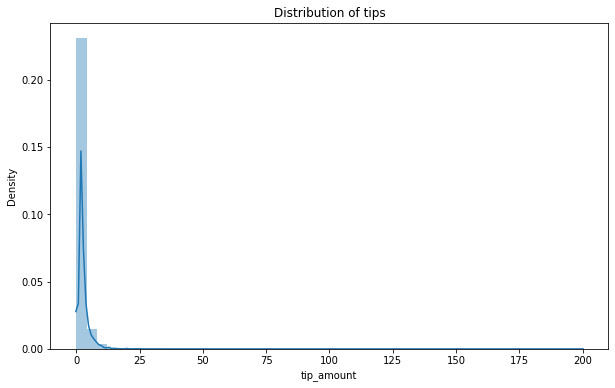

In [8]:
plt.figure(figsize = (10, 6))
sns.distplot(df['tip_amount'])
plt.title('Distribution of tips')
plt.show()

From graph above we understand that most of the data belongs to those who do not tip. Let’s explore more.

In [9]:
(len(df[df['tip_amount']!=0])/len(df))*100

52.27171327118887

In [10]:
(len(df[df['tip_amount']==0])/len(df))*100

47.728286728811135

Around 48% of passengers do not tip! Let's study the payment type and look for any correlation between tip amounts and the type of payments.

In [11]:
len(df[df['fare_amount']==0])

0

In [12]:
df['payment_type'].value_counts()

CRD    7952654
CSH    6799479
NOC      31733
DIS      11014
UNK       4721
Name: payment_type, dtype: int64

The majority of payments are done by cash or credit card

In [13]:
len(df[(df['payment_type']=='CSH')&(df['tip_amount']==0)])

6799159

In [14]:
len(df[(df['payment_type']=='CRD')&(df['tip_amount']==0)])

221925

In [15]:
len(df[(df['payment_type']=='NOC')&(df['tip_amount']==0)])

31692

In [16]:
len(df[(df['payment_type']=='DIS')&(df['tip_amount']==0)])

10680

In [17]:
len(df[(df['payment_type']=='UNK')&(df['tip_amount']==0)])

140

Total number of passengers who pay by cash are 6799479 and total number of passengers who pay by cash and do not tip are 6799159 (99.99%). In total only 320 passengers who paid by cash gave tip.

It is the same story for NOC and DIS payment types. The total number of passengers who use NOC as their payment are 31733 and among them there are only 41 records of passenger who gave tip. For DIS type of payment, there are in total 11014 records and only 334 records of tip giving passengers.  

At this point, we are not sure if these very large number of no-tip records for CSH, DIS and NOC are related to the non-registered data, or the passengers did not tip!

The maximum value for the tip does not look realistic. For getting a realistic amount we look at the maximum amount for the fare and consider 20% of that as a maximum for the tip amount. So, we consider any records bigger than this amount as an outlier.

In [18]:
df['tip_amount'].describe()

count    1.479960e+07
mean     1.337840e+00
std      2.072962e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      2.000000e+02
Name: tip_amount, dtype: float64

In [19]:
df['fare_amount'].describe()

count    1.479960e+07
mean     1.220303e+01
std      9.489329e+00
min      2.500000e+00
25%      6.500000e+00
50%      9.500000e+00
75%      1.400000e+01
max      1.000000e+02
Name: fare_amount, dtype: float64

We consider the maximum tip to be 20 USD.

In [20]:
df = df[df['tip_amount']<21]

With the outliers removed, the distribution looks much nicer.

C:\Users\Nastaran\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


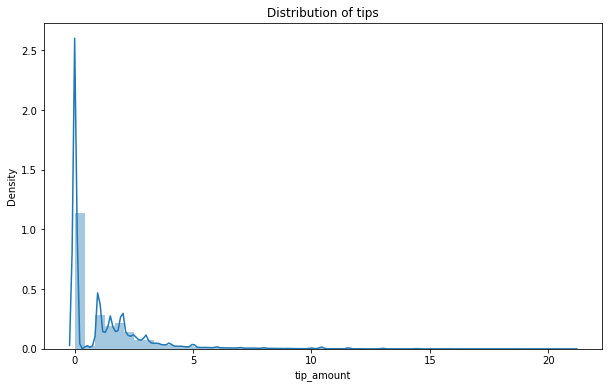

In [21]:
plt.figure(figsize = (10, 6))
sns.distplot(df['tip_amount'])
plt.title('Distribution of tips')
plt.show()

Lets check again for the percentage of tip/no-tip records.

In [22]:
print('The percentage of passengers who do not tip are {:.2f}%'.format((len(df[df['tip_amount']!=0])/len(df))*100))

The percentage of passengers who do not tip are 52.26%


In [23]:
print('The percentage of passengers who tip are {:.2f}%'.format((len(df[df['tip_amount']==0])/len(df))*100))

The percentage of passengers who tip are 47.74%


### Including date-time features


Convert the pickup and dropoff to the datetime

In [24]:
df['pickup_datetime']  = pd.to_datetime(df['pickup_datetime'])
df['dropoff_datetime']  = pd.to_datetime(df['dropoff_datetime'])


### Correlation

We randomly sample 300000 records and study the correlation.

In [25]:
ds=df.sample(300000)

In [26]:
ds = ds.drop(['pickup_datetime','dropoff_datetime', 'dropoff_longitude',
              'dropoff_latitude','dropoff_hour',
              'dropoff_day', 'trip_time_in_secs',
             'trip_distance', 'mta_tax', 'tolls_amount', 
              'surcharge','rate_code', 'passenger_count','vendor_id','payment_type'], axis =1 )

In [27]:
correlation = ds.corr()


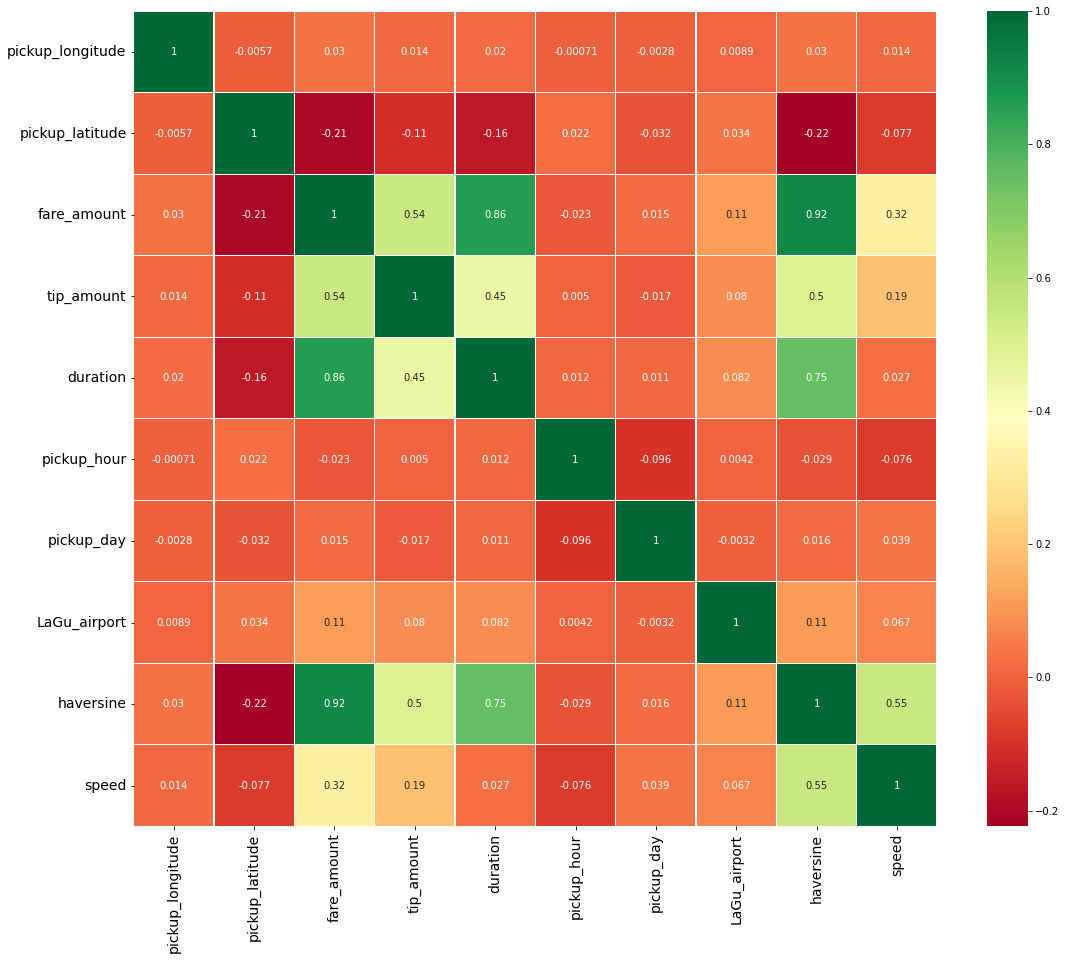

In [28]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Building Models

First we build a model based on only one features

In [29]:
ds.head()

,medallion,hack_license,pickup_longitude,pickup_latitude,fare_amount,tip_amount,duration,pickup_hour,pickup_day,LaGu_airport,haversine,speed
11341142,1F853ACD16D9788363C0813359D4261E,897829865BA5DBFAF3BED32507DA0F50,-73.996094,40.763893,10.5,0.0,709,9,2,False,2.603502,13.219476
13261234,04BC6422B122AEA5BF32379379F709AD,4199EB24AFD8D3F03CCCADB7BBBC7959,-73.922150,40.767185,5.0,0.0,180,4,2,False,1.058881,21.177619
5469745,BBAA52836EC682D5B5144247A68C92C9,75E5E58F8E074FBBD537751C2A6FF932,-73.993286,40.762794,10.0,1.0,614,21,1,False,2.354848,13.806927
2600464,B676BFC7597ECBD7963D0D2580B0030D,8EB374C18E588BD78AF3330F9C3E054B,-73.976334,40.755836,15.5,1.0,1200,19,1,False,4.991890,14.975671
11933557,86485F0B1CBDDD6FB6C993011A28B15D,658E5DCB02244AB457ED2FF730EF459A,-73.975563,40.764668,13.0,0.0,940,10,3,False,4.086951,15.652153


In [30]:
ds.loc[ds.tip_amount != 0, 'tip_amount'] = 1
ds.loc[ds.tip_amount == 0, 'tip_amount'] = 0

In [31]:
ds['tip_amount'].value_counts()

1.0    156725
0.0    143275
Name: tip_amount, dtype: int64

In [32]:
y = ds['tip_amount']
x = ds[['duration']]

In [33]:
x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.2)

In [34]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (240000, 1)
Testing data shape:  (60000, 1)


In [35]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
lr_y_pred = lr.predict(x_test)


In [37]:
lr_y_prob = lr.predict_proba(x_test)[:,1]


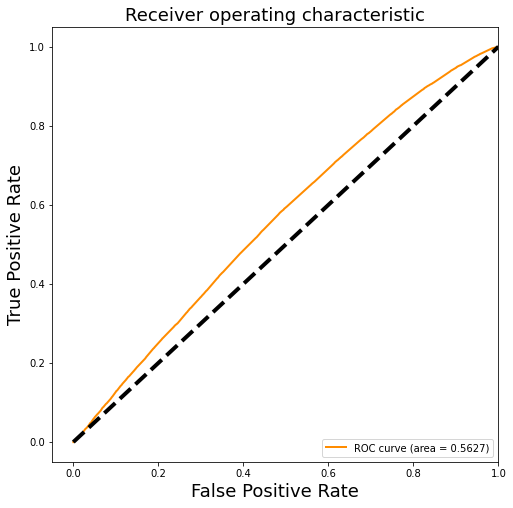

In [38]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [39]:
confusion_matrix(y_test, lr_y_pred)

array([[10931, 17705],
       [ 9077, 22287]], dtype=int64)

In [40]:
def summary_report(actual,prediction):
    
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

In [41]:
summary_report(y_test, lr_y_pred)

Accuracy : 0.5536 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5573 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7106 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


#### use all features

In [42]:
ds.head()

,medallion,hack_license,pickup_longitude,pickup_latitude,fare_amount,tip_amount,duration,pickup_hour,pickup_day,LaGu_airport,haversine,speed
11341142,1F853ACD16D9788363C0813359D4261E,897829865BA5DBFAF3BED32507DA0F50,-73.996094,40.763893,10.5,0.0,709,9,2,False,2.603502,13.219476
13261234,04BC6422B122AEA5BF32379379F709AD,4199EB24AFD8D3F03CCCADB7BBBC7959,-73.922150,40.767185,5.0,0.0,180,4,2,False,1.058881,21.177619
5469745,BBAA52836EC682D5B5144247A68C92C9,75E5E58F8E074FBBD537751C2A6FF932,-73.993286,40.762794,10.0,1.0,614,21,1,False,2.354848,13.806927
2600464,B676BFC7597ECBD7963D0D2580B0030D,8EB374C18E588BD78AF3330F9C3E054B,-73.976334,40.755836,15.5,1.0,1200,19,1,False,4.991890,14.975671
11933557,86485F0B1CBDDD6FB6C993011A28B15D,658E5DCB02244AB457ED2FF730EF459A,-73.975563,40.764668,13.0,0.0,940,10,3,False,4.086951,15.652153


Replace non zero tip values with 1 and the rest with 0.

In [43]:
ds.loc[df.tip_amount != 0, 'tip_amount'] = 1
ds.loc[df.tip_amount == 0, 'tip_amount'] = 0

In [44]:
ds['tip_amount'].value_counts()

1.0    156725
0.0    143275
Name: tip_amount, dtype: int64

Define target and the features

In [45]:
y = ds['tip_amount']
x = ds.drop(['tip_amount'], axis =1 )

In [46]:
x = x.set_index(['medallion', 'hack_license'])


In [47]:
x.head()

,,pickup_longitude,pickup_latitude,fare_amount,duration,pickup_hour,pickup_day,LaGu_airport,haversine,speed
medallion,hack_license,,,,,,,,,
1F853ACD16D9788363C0813359D4261E,897829865BA5DBFAF3BED32507DA0F50,-73.996094,40.763893,10.5,709,9,2,False,2.603502,13.219476
04BC6422B122AEA5BF32379379F709AD,4199EB24AFD8D3F03CCCADB7BBBC7959,-73.922150,40.767185,5.0,180,4,2,False,1.058881,21.177619
BBAA52836EC682D5B5144247A68C92C9,75E5E58F8E074FBBD537751C2A6FF932,-73.993286,40.762794,10.0,614,21,1,False,2.354848,13.806927
B676BFC7597ECBD7963D0D2580B0030D,8EB374C18E588BD78AF3330F9C3E054B,-73.976334,40.755836,15.5,1200,19,1,False,4.991890,14.975671
86485F0B1CBDDD6FB6C993011A28B15D,658E5DCB02244AB457ED2FF730EF459A,-73.975563,40.764668,13.0,940,10,3,False,4.086951,15.652153


In [48]:
x.shape

(300000, 9)

In [49]:
#Features name

features_name = list(x.columns)
features_name

['pickup_longitude',
 'pickup_latitude',
 'fare_amount',
 'duration',
 'pickup_hour',
 'pickup_day',
 'LaGu_airport',
 'haversine',
 'speed']

In [50]:
#Splitting the train and test data

x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.6)

In [51]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (120000, 9)
Testing data shape:  (180000, 9)


#### First Model: Logistic Regression

We create a simple logestic model.

In [52]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [53]:
lr_y_pred = lr.predict(x_test)


In [54]:
lr_y_prob = lr.predict_proba(x_test)[:,1]


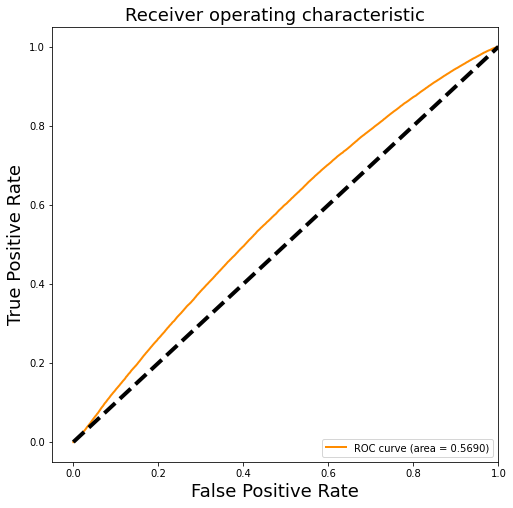

In [55]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [56]:
confusion_matrix(y_test, lr_y_pred)

array([[33917, 52040],
       [27521, 66522]], dtype=int64)

In [57]:
def summary_report(actual,prediction):
    
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

In [58]:
summary_report(y_test, lr_y_pred)

Accuracy : 0.5580 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.5611 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.7074 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [59]:
lr.coef_

array([[-0.68396132, -2.01048993,  0.34125691,  3.24580014,  0.06620221,
        -0.175045  ,  0.02400656, -2.1655052 ,  1.16646288]])

In [60]:
coef_table = pd.DataFrame(list(features_name)).copy()
coef_table.insert(len(coef_table.columns),"Coefs",lr.coef_.transpose())

In [61]:
coef_table

,0,Coefs
0,pickup_longitude,-0.683961
1,pickup_latitude,-2.010490
2,fare_amount,0.341257
3,duration,3.245800
4,pickup_hour,0.066202
5,pickup_day,-0.175045
6,LaGu_airport,0.024007
7,haversine,-2.165505
8,speed,1.166463


#### Different approch

The second approach is to remove all the payment type related to CSH, DIS and NOC which have the major amounts of no-tip records. We assume that the high records for zero tip might be related to non-registered data. So, we build a model based on CRD and UNK payment type.

first we create some random sample from our main dataset.

In [62]:
ds=df.sample(300000)

Replace non zero tip values with 1 and the rest with 0.

In [63]:
ds.loc[df.tip_amount != 0, 'tip_amount'] = 1
ds.loc[df.tip_amount == 0, 'tip_amount'] = 0

ds['tip_amount'].value_counts()

1.0    156555
0.0    143445
Name: tip_amount, dtype: int64

In [64]:
ds = ds.drop(ds[(ds['payment_type']=='CSH')].index, axis=0)

In [65]:
ds = ds.drop(ds[(ds['payment_type']=='DIS')|(ds['payment_type']=='NOC')].index, axis=0)

In [66]:
ds.payment_type.unique()

array(['CRD', 'UNK'], dtype=object)

In [67]:
ds = ds.drop(['pickup_datetime','dropoff_datetime', 'dropoff_longitude',
              'dropoff_latitude','dropoff_hour',
              'dropoff_day', 'trip_time_in_secs',
             'trip_distance', 'mta_tax', 'tolls_amount', 
              'surcharge','rate_code', 'passenger_count','vendor_id','payment_type'], axis =1 )

In [68]:
y = ds['tip_amount']
x = ds.drop(['tip_amount'], axis =1 )

In [69]:
y.value_counts()

1.0    156536
0.0      4570
Name: tip_amount, dtype: int64

The target data is imbalance. We study it further below

In [70]:
x = x.set_index(['medallion', 'hack_license'])


In [71]:
x.head()

,,pickup_longitude,pickup_latitude,fare_amount,duration,pickup_hour,pickup_day,LaGu_airport,haversine,speed
medallion,hack_license,,,,,,,,,
FFB2AA0A5F7EA57B18799EB60CB5E792,208293D063814ED3E58EBB118E7E25AE,-73.993301,40.737644,13.5,811,20,2,False,5.013232,22.253559
B48B1375CD301CADFC4AA5208B5C157C,0AD8D9ED455E6C0A5737A7F4D508506B,-74.016380,40.705521,17.0,960,13,2,False,5.851636,21.943634
FC10E421AAE21F8BAAB9CD33B116BF34,DCF73C716FDC0975D728DDCD335C7AF7,-73.985626,40.718006,14.5,615,3,6,False,6.067691,35.518190
EF10D5A08A0D103A1701537C93FD55AC,9C214D350ED6FC5C321306CEB53D23C4,-73.959618,40.760208,9.0,673,7,0,False,1.624635,8.690469
B0B78CD05C8A1737E24F87459FC04B33,27B041361D07EE9FAD1F51C099204E18,-73.996933,40.737316,8.5,584,21,5,False,2.260813,13.936520


In [72]:
x.shape

(161106, 9)

In [73]:
#Spliting the train and test data

x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.2)

In [74]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (128884, 9)
Testing data shape:  (32222, 9)


In [75]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [76]:
lr_y_pred = lr.predict(x_test)


In [77]:
lr_y_prob = lr.predict_proba(x_test)[:,1]


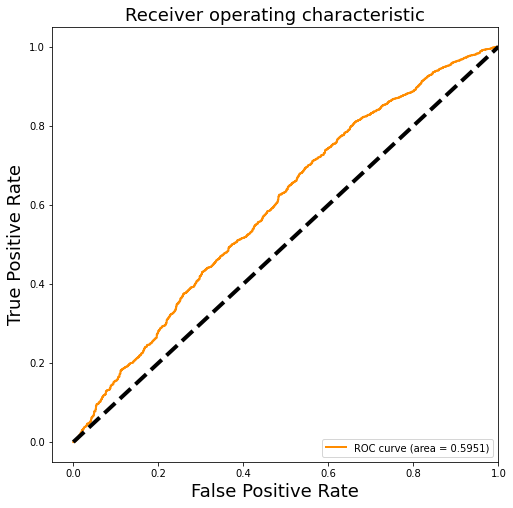

In [78]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [79]:
confusion_matrix(y_test, lr_y_pred)

array([[    0,   902],
       [    0, 31320]], dtype=int64)

In [80]:
def summary_report(actual,prediction):
    
    accuracy_ = accuracy_score(actual, prediction)
    precision_ = precision_score(actual, prediction)
    recall_ = recall_score(actual, prediction)
    
    print('Accuracy : %.4f [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0' % accuracy_)
    print('Precision: %.4f [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0' % precision_)
    print('Recall   : %.4f [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0' % recall_)
    print('-' * 107)
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')

In [81]:
summary_report(y_test, lr_y_pred)

Accuracy : 0.9720 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9720 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


### Second Model: Random Forest


In [82]:
random_forest = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1)


In [83]:
random_forest.fit(x_train,y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   48.1s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [84]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': x, 'importance': feature_importance_values})

In [85]:
feature_importances


,feature,importance
0,"(p, i, c, k, u, p, _, l, o, n, g, i, t, u, d, e)",0.170690
1,"(p, i, c, k, u, p, _, l, a, t, i, t, u, d, e)",0.179220
2,"(f, a, r, e, _, a, m, o, u, n, t)",0.077279
3,"(d, u, r, a, t, i, o, n)",0.107306
4,"(p, i, c, k, u, p, _, h, o, u, r)",0.072071
5,"(p, i, c, k, u, p, _, d, a, y)",0.047780
6,"(L, a, G, u, _, a, i, r, p, o, r, t)",0.000693
7,"(h, a, v, e, r, s, i, n, e)",0.173625
8,"(s, p, e, e, d)",0.171335


In [86]:
rf_y_pred = random_forest.predict(x_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.7s finished


In [87]:
rf_y_prob = random_forest.predict_proba(x_test)[:, 1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished


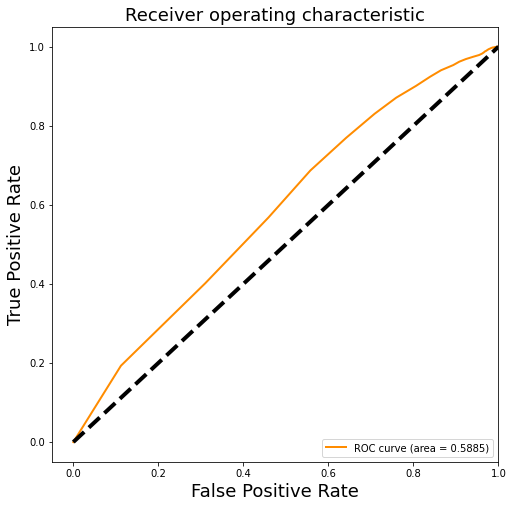

In [88]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, rf_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [89]:
summary_report(y_test, rf_y_pred)


Accuracy : 0.9719 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9720 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.9999 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


#### Random Forest: different hyperparameter


In [90]:
rf = RandomForestClassifier(n_estimators = 1000, criterion='entropy',class_weight='balanced', max_depth=10 ,random_state = 50, verbose = 1)


In [91]:
rf.fit(x_train,y_train)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:  4.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [92]:
rf_y_pred = rf.predict(x_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.6s finished


In [93]:
rf_y_prob = rf.predict_proba(x_test)[:, 1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.8s finished


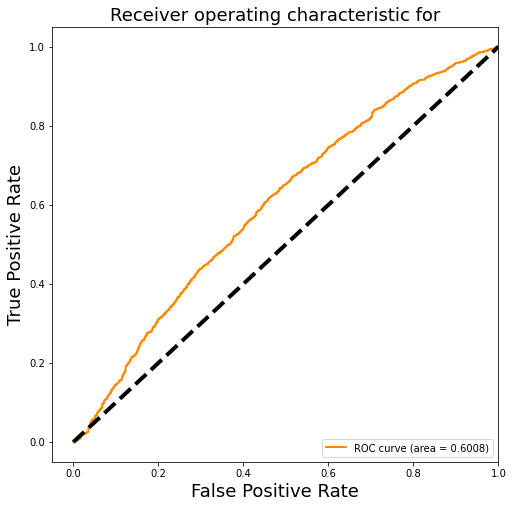

In [94]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, rf_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [95]:
summary_report(y_test, rf_y_pred)


Accuracy : 0.8568 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9756 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.8745 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [96]:
feature_importance_values = rf.feature_importances_


In [97]:
feature_importances = pd.DataFrame({'feature': list(x.columns), 'importance': feature_importance_values})


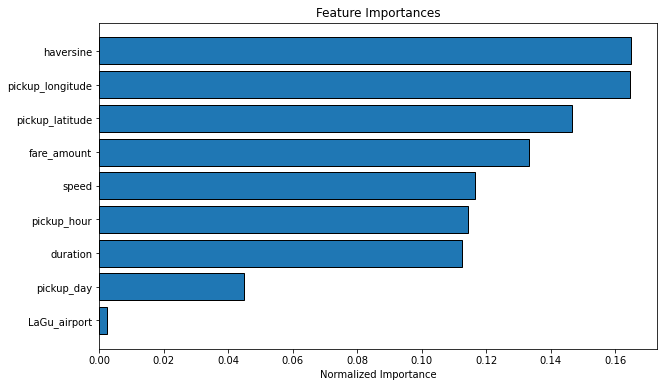

In [98]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

### Third Model: XGBoost

In [99]:
xgb = XGBClassifier(binary='logistic', random_state=50, )


In [100]:
xgb.fit(x_train,y_train)


XGBClassifier(base_score=0.5, binary='logistic', booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=50,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [101]:
xgb_y_pred = xgb.predict(x_test)


In [102]:
xgb_y_prob = xgb.predict_proba(x_test)[:, 1]


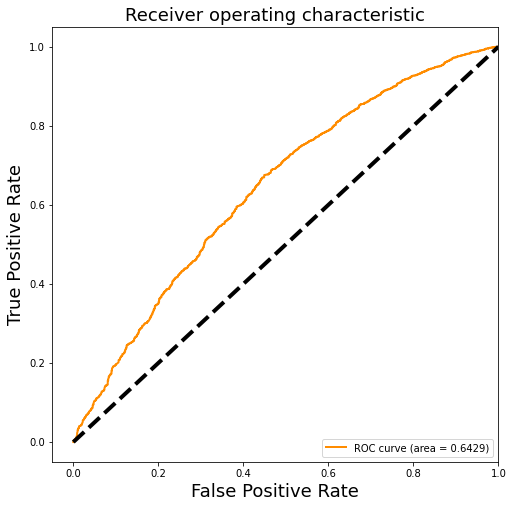

In [103]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, xgb_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [104]:
summary_report(y_test, xgb_y_pred)


Accuracy : 0.9720 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9720 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 1.0000 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [105]:
#importance feature
feature_importance_values = xgb.feature_importances_

In [106]:
feature_importances = pd.DataFrame({'feature': list(x.columns), 'importance': feature_importance_values})


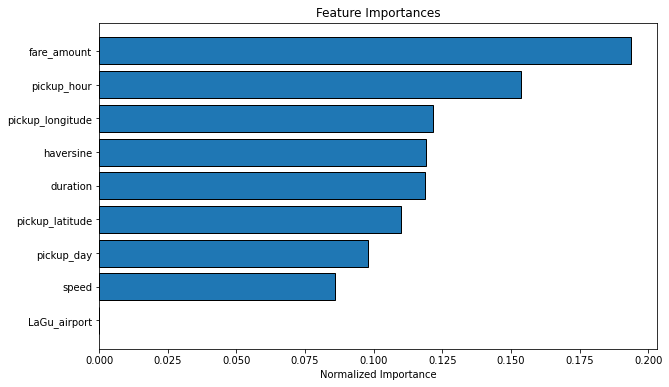

In [107]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

### Imbalanced data set- Over Sampling

In [108]:
ds.head()

,medallion,hack_license,pickup_longitude,pickup_latitude,fare_amount,tip_amount,duration,pickup_hour,pickup_day,LaGu_airport,haversine,speed
7276649,FFB2AA0A5F7EA57B18799EB60CB5E792,208293D063814ED3E58EBB118E7E25AE,-73.993301,40.737644,13.5,1.0,811,20,2,False,5.013232,22.253559
6234553,B48B1375CD301CADFC4AA5208B5C157C,0AD8D9ED455E6C0A5737A7F4D508506B,-74.016380,40.705521,17.0,1.0,960,13,2,False,5.851636,21.943634
1304706,FC10E421AAE21F8BAAB9CD33B116BF34,DCF73C716FDC0975D728DDCD335C7AF7,-73.985626,40.718006,14.5,1.0,615,3,6,False,6.067691,35.518190
5708612,EF10D5A08A0D103A1701537C93FD55AC,9C214D350ED6FC5C321306CEB53D23C4,-73.959618,40.760208,9.0,1.0,673,7,0,False,1.624635,8.690469
10878915,B0B78CD05C8A1737E24F87459FC04B33,27B041361D07EE9FAD1F51C099204E18,-73.996933,40.737316,8.5,1.0,584,21,5,False,2.260813,13.936520


In [109]:
y = ds['tip_amount']
x = ds.drop(['tip_amount'], axis =1 )

In [110]:
y.value_counts()

1.0    156536
0.0      4570
Name: tip_amount, dtype: int64

In [111]:
x.shape

(161106, 11)

In [112]:
x = x.drop(['medallion', 'hack_license'],axis=1)


In [113]:
correlation = x.corr()


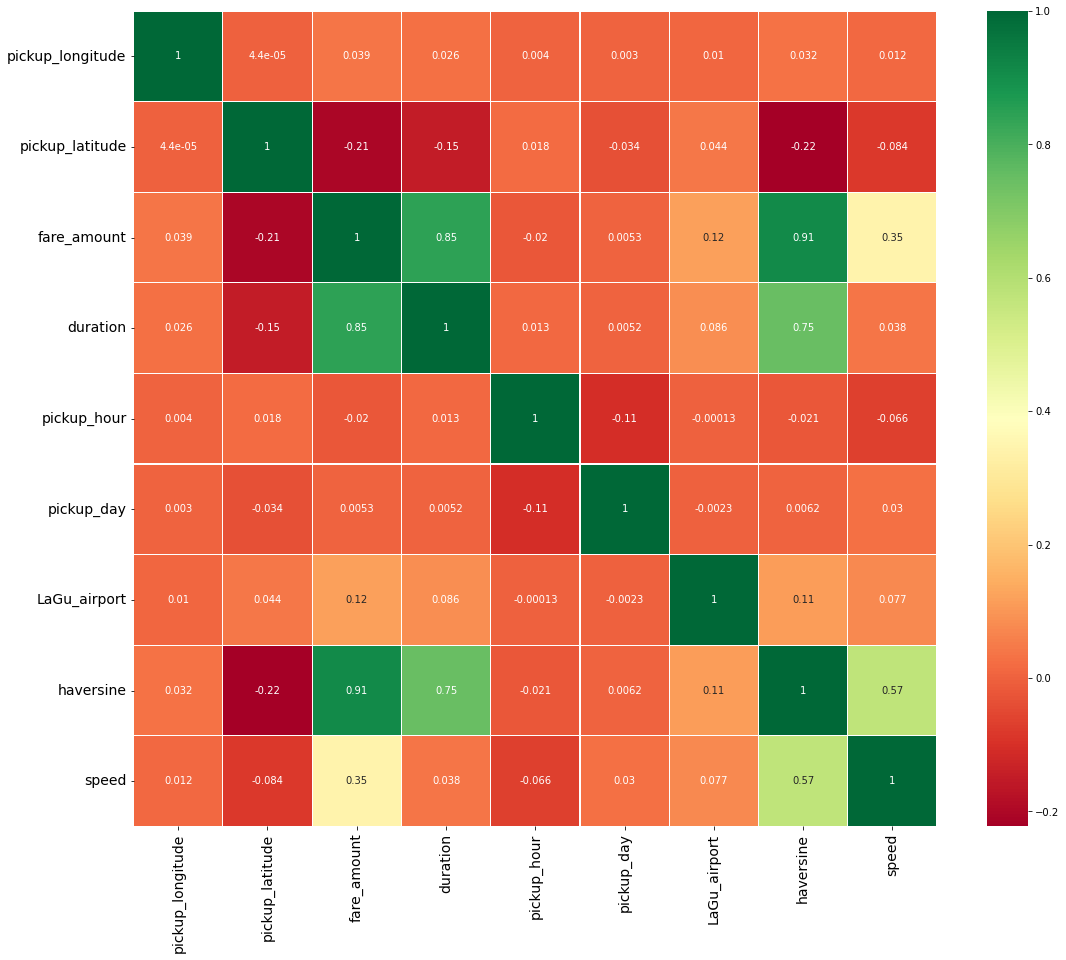

In [114]:
plt.figure(figsize=(10,8))
sns.heatmap(correlation,annot=True,cmap='RdYlGn',linewidths=0.2,annot_kws={'size':10})
fig=plt.gcf()
fig.set_size_inches(18,15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [115]:
x.dtypes

pickup_longitude    float64
pickup_latitude     float64
fare_amount         float64
duration              int64
pickup_hour           int64
pickup_day            int64
LaGu_airport           bool
haversine           float64
speed               float64
dtype: object

In [116]:
x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 42, test_size=0.2)


In [117]:
features = x_train.columns
features

Index(['pickup_longitude', 'pickup_latitude', 'fare_amount', 'duration',
       'pickup_hour', 'pickup_day', 'LaGu_airport', 'haversine', 'speed'],
      dtype='object')

In [118]:
df_train = pd.concat((x_train, y_train), axis=1)


In [119]:
df_train.head()

,pickup_longitude,pickup_latitude,fare_amount,duration,pickup_hour,pickup_day,LaGu_airport,haversine,speed,tip_amount
1690892,-73.957901,40.719635,16.5,1513,23,5,False,2.367998,5.634363,1.0
14551569,-74.004044,40.720875,17.0,1500,9,0,False,4.527204,10.865290,1.0
1470779,-73.978058,40.773891,5.0,241,18,4,False,1.379055,20.599990,1.0
8759578,-73.979759,40.762520,9.5,540,11,5,False,3.175721,21.171475,1.0
14237837,-73.995377,40.759781,10.0,660,22,5,False,2.058019,11.225559,1.0


### Over-sampling


In [120]:
df_train['tip_amount'].value_counts()

1.0    125217
0.0      3667
Name: tip_amount, dtype: int64

In [121]:
#class count
count_class_1, count_class_0 = df_train['tip_amount'].value_counts()

In [122]:
print(count_class_0)
print(count_class_1)

3667
125217


In [123]:
#Divide by class
df_class_0 = df_train[df_train['tip_amount'] == 0]
df_class_1 = df_train[df_train['tip_amount'] == 1]

In [124]:
df_class_1_under = df_class_1.sample(count_class_0)


In [125]:
df_under = pd.concat([df_class_1_under, df_class_0], axis=0)


In [126]:
print('Random under_sampling:')
print(df_under['tip_amount'].value_counts())

Random under_sampling:
0.0    3667
1.0    3667
Name: tip_amount, dtype: int64


### Modeling

In [127]:
y = df_under['tip_amount']
x = df_under.drop(['tip_amount'], axis =1 )

In [128]:
# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x)
x = scaler.transform(x)
x_test = scaler.transform(x_test)

print('Training data shape: ', x.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (7334, 9)
Testing data shape:  (32222, 9)


#### 4.1 Logestic Regression


In [129]:
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr.fit(x, y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [130]:
lr_y_pred = lr.predict(x_test)
lr_y_prob = lr.predict_proba(x_test)[:,1]

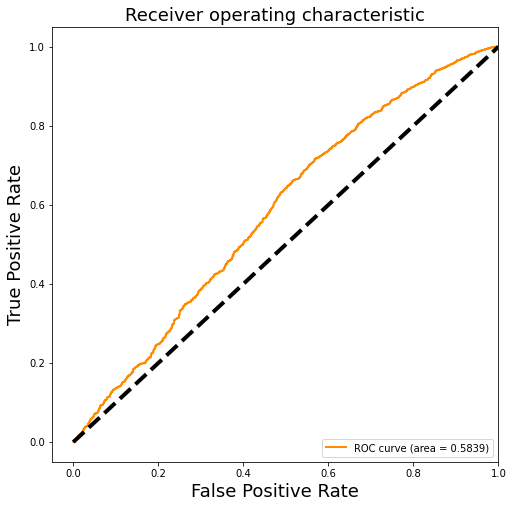

In [131]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, lr_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (has_cancer)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [132]:
confusion_matrix(y_test, lr_y_pred)


array([[  438,   465],
       [10713, 20606]], dtype=int64)

In [133]:
summary_report(y_test, lr_y_pred)


Accuracy : 0.6531 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9779 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6579 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


#### 4.2 Random Forest

In [134]:
rf = RandomForestClassifier(n_estimators = 1000, criterion='entropy', max_depth=10 ,random_state = 50, verbose = 1)


In [135]:
rf.fit(x,y)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:   13.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=None, oob_score=False, random_state=50, verbose=1,
                       warm_start=False)

In [136]:
rf_y_pred = rf.predict(x_test)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    2.8s finished


In [137]:
rf_y_prob = rf.predict_proba(x_test)[:, 1]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    3.0s finished


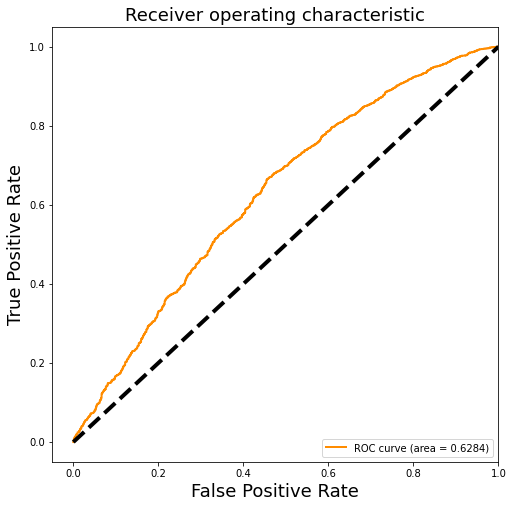

In [138]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, rf_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [139]:
summary_report(y_test, rf_y_pred)


Accuracy : 0.6366 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9804 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.6390 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [140]:
#importance feature
feature_importance_values = rf.feature_importances_

In [141]:
feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importance_values})

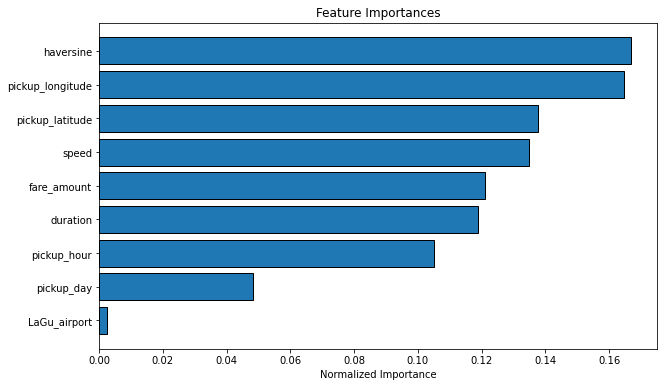

In [142]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

#### 4.3 XGBoost


In [143]:
xgb = XGBClassifier(binary='logistic', random_state=50, max_depth=10, reg_alpha=10 )


In [144]:
xgb.fit(x,y)


XGBClassifier(base_score=0.5, binary='logistic', booster='gbtree',
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=50,
              reg_alpha=10, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [145]:
xgb_y_pred = xgb.predict(x_test)


In [146]:
xgb_y_prob = xgb.predict_proba(x_test)[:, 1]


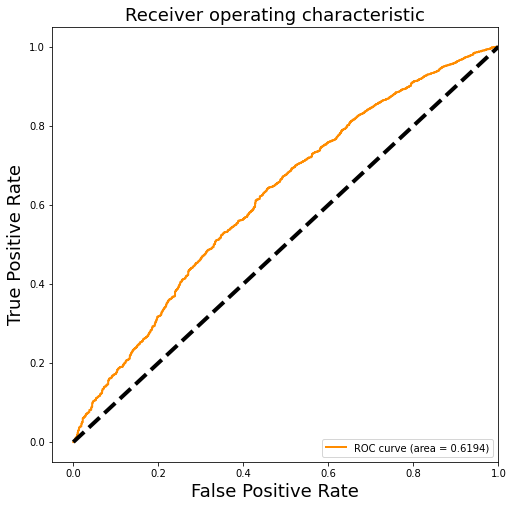

In [147]:
# For class 1, find the area under the curve

# Find fpr, tpr

fpr, tpr, _ = roc_curve(y_test, xgb_y_prob)

# Find auc

roc_auc = auc(fpr, tpr)

#Plot of a ROC curve for class 1 (default)
plt.figure(figsize=[8,8])

#Plot fpr, tpr
plt.plot(fpr, tpr, color='darkorange', lw = 2, label = 'ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic', fontsize=18)
plt.legend(loc="lower right")
plt.show()

In [148]:
summary_report(y_test, xgb_y_pred)


Accuracy : 0.5843 [TP / N] Proportion of predicted labels that match the true labels. Best: 1, Worst: 0
Precision: 0.9798 [TP / (TP + FP)] Not to label a negative sample as positive.        Best: 1, Worst: 0
Recall   : 0.5843 [TP / (TP + FN)] Find all the positive samples.                     Best: 1, Worst: 0
-----------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples


In [149]:
feature_importance_values_xgb = xgb.feature_importances_


In [150]:
feature_importances = pd.DataFrame({'feature': list(features), 'importance': feature_importance_values_xgb})

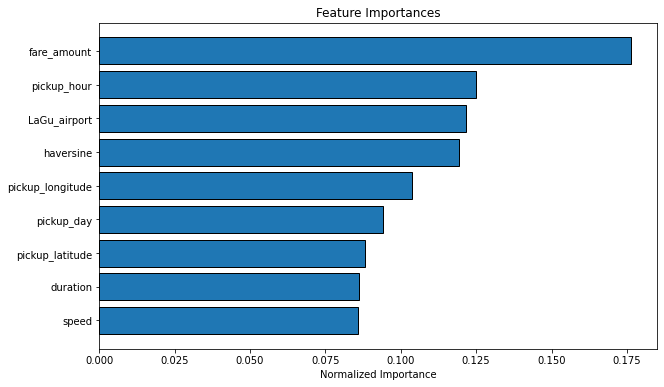

In [151]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labeling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()

## Part 2: Predicting tip using regression models

In [152]:
ds = df.sample(300000)

ds = ds.drop(['pickup_datetime','dropoff_datetime', 'dropoff_longitude',
              'dropoff_latitude','dropoff_hour',
              'dropoff_day', 'trip_time_in_secs',
             'trip_distance', 'mta_tax', 'tolls_amount', 
              'surcharge','rate_code', 'passenger_count','vendor_id','payment_type'], axis =1 )

y = ds['tip_amount']
x = ds.drop(['tip_amount'], axis =1 )
x = x.set_index(['medallion', 'hack_license'])


In [153]:
x_train,x_test, y_train,y_test = train_test_split(x,y, random_state = 20, test_size=0.2)

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data and transform both training and testing data
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

print('Training data shape: ', x_train.shape)
print('Testing data shape: ', x_test.shape)

Training data shape:  (240000, 9)
Testing data shape:  (60000, 9)


#### Linear regression

In [154]:
lr = LinearRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

RMSE: 1.682
MAE: 1.235


#### Random Forest

In [155]:
# Create the random forest
random_forest = RandomForestRegressor()

# Train on data
random_forest.fit(x_train, y_train)

# predict 
y_pred = random_forest.predict(x_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: %.3f' % (rmse))

mae = mean_absolute_error(y_test, y_pred)
print('MAE: %.3f' % (mae))

RMSE: 1.682
MAE: 1.213


Text(0.5, 1.0, 'Distribution of Validation tips')

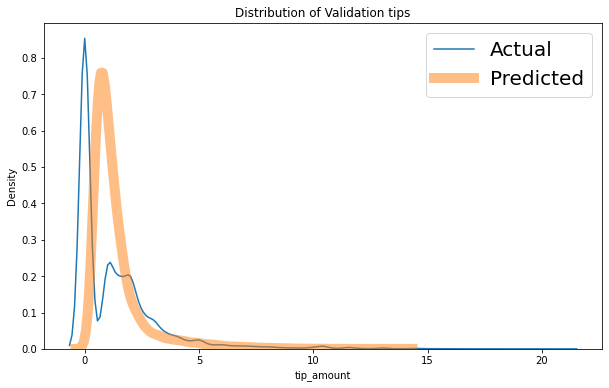

In [156]:
plt.figure(figsize = (10, 6))

sns.kdeplot(y_test, label = 'Actual')
sns.kdeplot(y_pred, label = 'Predicted',linewidth=10,alpha=.5)
plt.legend(prop = {'size': 20})
plt.title("Distribution of Validation tips")

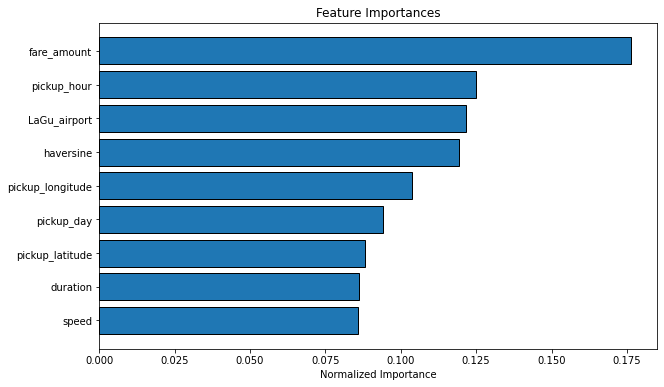

In [157]:
feature_importances = feature_importances.sort_values('importance', ascending = False).reset_index()
    
# Normalize the feature importances to add up to one
feature_importances['importance_normalized'] = feature_importances['importance'] / feature_importances['importance'].sum()

# Make a horizontal bar chart of feature importances
plt.figure(figsize = (10, 6))
ax = plt.subplot()
    
# Need to reverse the index to plot most important on top
ax.barh(list(reversed(list(feature_importances.index[:15]))), 
feature_importances['importance_normalized'].head(15), align = 'center', edgecolor = 'k')
    
# Set the yticks and labels
ax.set_yticks(list(reversed(list(feature_importances.index[:15]))))
ax.set_yticklabels(feature_importances['feature'].head(15))
    
# Plot labelling
plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
plt.show()